In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import pandas as pd
import sys
libPathList = ['../fortran/', '../.']
for libPath in libPathList:
    sys.path.insert(0,libPath)
from myfastmodule import fast_foward_model as ffm

## Plot of the East River Topography

In [3]:
dem_base = pathlib.Path("/Volumes/Transcend/ASOdata/DEMs")
dem = xr.open_rasterio(dem_base.joinpath("3mdem_upsample_50m_clipped_to_east.tif"))

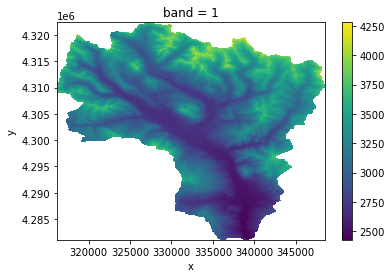

In [4]:
dem.where(dem>0).plot()

In [9]:
east_river_area_m2 = 748983000.0 # m2


# Basin Hypsometry

Text(0.5, 1.0, 'Basin Hypsometry')

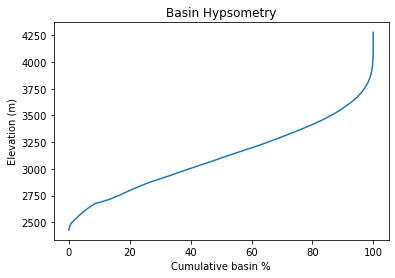

In [5]:
flat_dem = dem.values.flatten()
flat_dem_east = flat_dem[np.where(flat_dem > 0)]
flat_dem_east_sort = np.sort(flat_dem_east)
prcnt = np.linspace(0,100, len(flat_dem_east_sort))

plt.plot(prcnt, flat_dem_east_sort)
plt.ylabel("Elevation (m)")
plt.xlabel("Cumulative basin %")
plt.title("Basin Hypsometry")

# Plot Snotel Observations

In [6]:
database = "/Volumes/Transcend/EastRiverClimatePaper/Snotel/CO_snotel.db"
dbengine = "sqlite:///{}".format(database)

# select the snotel station X
df = pd.read_sql_table('380', dbengine)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# get the number of times...
ntimes = len(df.index)
days = df.index.dayofyear.values

# comptue/fix the forcing data
DailyPrecipForcing = df.IncPrecip.fillna(0) * 25.4
DailyTempForcing = ((df.TavgF-32.0)*5/9)
DailyTempForcing = DailyTempForcing.fillna(DailyTempForcing.mean())

NotImplementedError: read_sql_table only supported for SQLAlchemy connectable.

In [ ]:
start, end = "2018-10-01", "2019-09-30"
fig,ax = plt.subplots()
fig.set_size_inches(10,6)
ax1 = plt.twinx(ax)
ax.plot(DailyPrecipForcing.loc[start:end], label='precip')
ax1.plot(DailyTempForcing.loc[start:end], color='red', label='temp')
ax1.set_ylim(-25,20)
ax1.set_ylabel('degC')
ax.set_ylabel('mm')
plt.legend()

# Get the USGS Streamflow info

In [28]:
## --- Gather the USGS stream observations ----#
columns = ['usgs', 'id', 'date', 'timezone', 'discharge', 'flag']
usgs_df = pd.read_csv('../data/usgs_data.txt', skiprows=41, sep='\t', names = columns)
usgs_df['date'] = pd.to_datetime(usgs_df.date)
usgs_df.set_index('date', inplace=True)

# there might be missing data -- reinterpolate to correct time (adds timesteps)
# go from hourly --> daily
usgs_df = usgs_df.resample("D").mean()
usgs_df = usgs_df.interpolate()
del usgs_df['id']




### Convert discharge m3/s to unit discharge
$$\frac{\text{discharge} (m^3/s) * \text{length-of-time(s)}}{\text{watershed area}(m^2)} * \frac{1000mm}{m}$$

In [ ]:
# convert discharge to units of discharge per unit area 
usgs_df['discharge_m3s'] = usgs_df['discharge']* 0.0283  # convert to m3/s
usgs_df['discharge_unit_mm'] = usgs_df['discharge_m3s'] * (24*60*60)/east_river_area_m2*1000
#       usgs_df = usgs_df.loc[start:end]


Text(0, 0.5, 'm3/s')

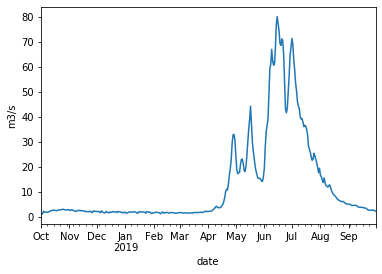

In [80]:
fig,ax = plt.subplots(1)
usgs_df.loc[start:end].discharge_m3s.plot(ax=ax)
ax.set_ylabel('m3/s')

Text(0, 0.5, 'mm')

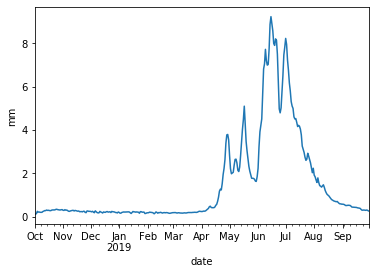

In [29]:
fig,ax = plt.subplots(1)
usgs_df.loc[start:end].discharge_unit_mm.plot(ax=ax)
ax.set_ylabel('mm')

Text(0, 0.5, 'mm')

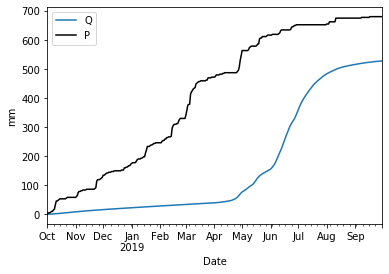

In [35]:
fig,ax = plt.subplots(1)
usgs_df.loc[start:end].discharge_unit_mm.cumsum().plot(ax=ax, label='Q')
DailyPrecipForcing.loc[start:end].cumsum().plot(ax=ax, label='P', color='black')
ax.legend()
ax.set_ylabel('mm')

# Plot Precip and Discharge 

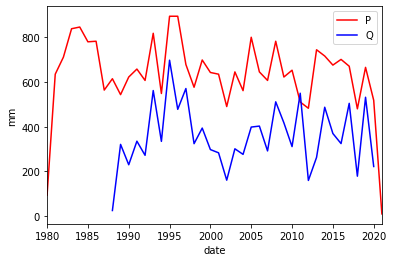

In [11]:
DailyPrecipForcing.groupby(DailyPrecipForcing.index.year).sum().plot(color='red', label='P')
usgs_df['discharge_unit_mm'].groupby(usgs_df.index.year).sum().plot(color='blue', label='Q')
plt.ylabel("mm")
plt.legend()

### Plot difference orographic preciptiation amounts

## $$P_z = P_{z_0}(1 + opg*dz)$$
### $$dz = z-z_0$$


In [38]:
dz = np.load("../data/dz_reduced.npy")


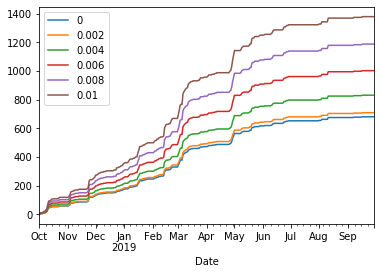

In [77]:
fig,ax = plt.subplots(1)
orog_gradiets = [0, .002, .004, .006, .008, .01] # km^(-1)

def pmapper(x, ogp, dz):
    z = x +  x*ogp*dz
    zz = np.mean(np.where(z>0, z, 0))
    return zz


for opg_i in orog_gradiets:
     _pm = lambda x: pmapper(x, opg_i, dz)
     DailyPrecipForcing.loc[start:end].apply(_pm).cumsum().plot(label=opg_i, ax=ax)

plt.legend()

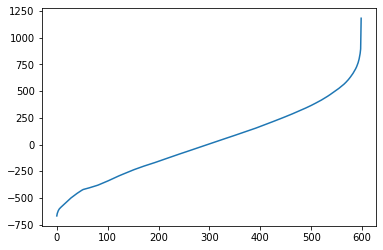

In [50]:
plt.plot(dz)

## Simple Lumped Model...
# $$ f(P, T, ?, \theta_n) = Q + \epsilon$$
### Forcing variables are precipitation, temperature. Other forcings could be used in addition. 

In [5]:
PdVec = DailyPrecipForcing.loc[start:end]
TdVec = DailyTempForcing.loc[start:end]

LenOfDayHr = [DayLength_Calc(d, lat=38.0) for d in PdVec.index.dayofyear.values]

for i in range(100):
	frtdir = .09 
	frtgw  = .06 
	smcap = 200 
	etpar = .09 
	tmelt = .01 
	t_snow = 0.0 
	t_melt = 1.0 
	t_base = 1.2 
	t_power = .5  
	opg  = .002 
	bias = 0 


	model = ffm.fwd(3, PdVec, TdVec, LVec, dz, frtdir, frtgw, smcap, etpar, t_snow, t_melt, t_base, t_power, bias, opg)
	plt.plot(model, color='blue', alpha=.1)

NameError: name 'DailyPrecipForcing' is not defined